In [1]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.explain.metric import fidelity
from torch_geometric.explain import ModelConfig, ExplainerConfig, GNNExplainer
from torch_geometric.explain import Explainer

In [2]:
%run utils.ipynb
%run gcn_model.ipynb
%run GAT_model.ipynb

In [3]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [4]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
labels_new = labels[labels["class"] != "unknown"]
nodes_new =  nodes.take(indexes)
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

((46564, 167), (46564, 2), (36624, 2))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
data, graph_info = create_graph(nodes_new, edges_new, labels_new, device)
data

Data(x=[46564, 165], edge_index=[2, 36624], y=[46564])

In [7]:
# generate test and train masks
train_p = 0.8
# indices of the illicit and licit transaction nodes
illicit_idx = (data.y == 0).nonzero(as_tuple=True)[0]
# Generate random permutation of indices
illicit_train, illicit_test = torch.utils.data.random_split(illicit_idx, lengths=[train_p, (1-train_p)])

# the same for the licit nodes
licit_idx   = (data.y == 1).nonzero(as_tuple=True)[0]
licit_train, licit_test = torch.utils.data.random_split(licit_idx, lengths=[train_p, (1-train_p)])
# obtain the training and test "masks", i.e. indices for the train and test sets
train_mask = torch.cat((torch.tensor(illicit_train), torch.tensor(licit_train)))
test_mask  = torch.cat((torch.tensor(illicit_test), torch.tensor(licit_test)))

In [8]:
loader = DataLoader([data], batch_size = 1)

In [27]:
GCN = GNN_Example(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [28]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GCN.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_test_loss = 0
best_result = None
train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GCN, loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(GCN, loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(GCN)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gcn.pt")

Epoch:  10
0 ({'precision': 0.7425742574257426, 'recall': 0.08259911894273128, 'f1-score': 0.14866204162537167, 'support': 908})
1 ({'precision': 0.9095548317046689, 'recall': 0.9969058669522789, 'f1-score': 0.951229205700335, 'support': 8403})
accuracy (0.9077435291590592)
macro avg ({'precision': 0.8260645445652057, 'recall': 0.539752492947505, 'f1-score': 0.5499456236628533, 'support': 9311})
weighted avg ({'precision': 0.8932710424827525, 'recall': 0.9077435291590592, 'f1-score': 0.8729636074853132, 'support': 9311})
############################
Epoch:  20
0 ({'precision': 0.9157303370786517, 'recall': 0.538546255506608, 'f1-score': 0.6782246879334258, 'support': 908})
1 ({'precision': 0.952261592799362, 'recall': 0.9946447697250982, 'f1-score': 0.9729918509895228, 'support': 8403})
accuracy (0.9501664697669423)
macro avg ({'precision': 0.9339959649390068, 'recall': 0.766595512615853, 'f1-score': 0.8256082694614744, 'support': 9311})
weighted avg ({'precision': 0.9486990989539742, 

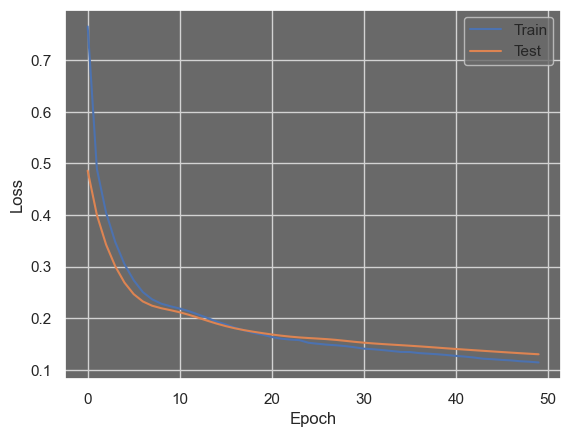

In [29]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [30]:
# class 1 lict
# class 0 ilicit
c, w = get_ilicit_predictions(GCN, loader, test_mask, device)
c, w = c[0], w[0]
print(c.shape, w.shape)

(670,) (238,)


In [13]:
# node_index =[8440, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808]
#[8041, 8107, 8157, 8170, 8368, 8394, 8415, 8439, 8440, 8455, 8493, 8496, 8530, 8567, 8568, 8579, 8590, 8594, 8612, 8624, 8657, 8674, 8687, 8696, 8716, 8728, 8734, 8757, 8760, 8762, 8763, 8765, 8773, 8776, 8808, 8814, 8819, 8827, 8845, 8846, 8856, 8874, 8882, 8900, 8902, 8912, 8915, 8921, 8946, 8986, 8987] #illicit_idx[:200].tolist()
explainer = Explainer(
    model=GCN,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    )
)
explanation_correct = explainer(data.x, data.edge_index, index=c)
explanation_wrong = explainer(data.x, data.edge_index, index=w)

In [31]:
fid_pm = fidelity(explainer, explanation_correct)
print(fid_pm)
explanation_correct.visualize_graph('subgraph_correct.png', backend="networkx")


fid_pm = fidelity(explainer, explanation_wrong)
print(fid_pm)
explanation_wrong.visualize_graph('subgraph_wrong.png', backend="networkx")

(0.10432189702987671, 0.0)
(0.09282702207565308, 5.960464477539063e-08)


62


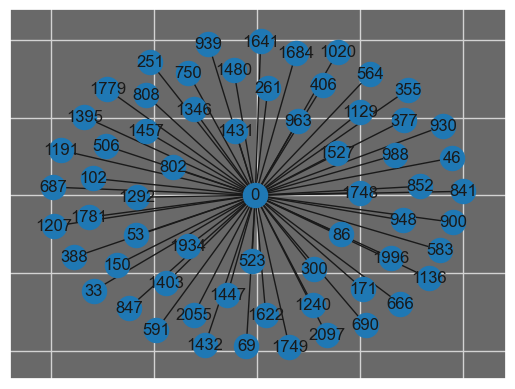

In [15]:
import networkx as nx

index  = 0
edge_list = data.edge_index.cpu().detach().numpy()
G = nx.from_edgelist(edge_list.T)
n = list(G.neighbors(c[index]))
n.append(c[index])
g = G.subgraph(n)
nx.draw_networkx(g)
print(G.degree(c[index]))


23


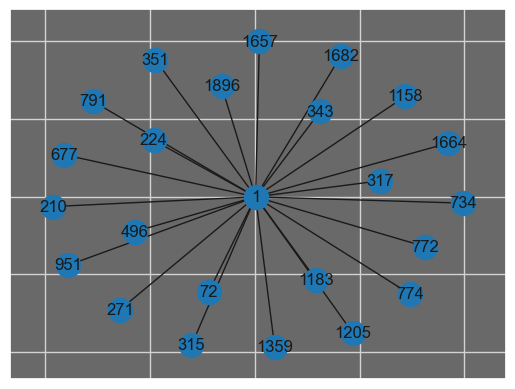

In [16]:
edge_list = data.edge_index.cpu().detach().numpy()
G = nx.from_edgelist(edge_list.T)
n = list(G.neighbors(w[index]))
n.append(w[index])
g = G.subgraph(n)
nx.draw_networkx(g)
print(G.degree(w[index]))

2.399665551839465 3.3129622623400916 598
3.6142857142857143 16.93485517292342 210


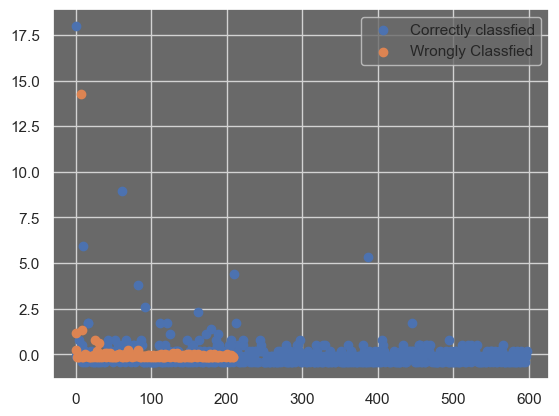

In [32]:
import numpy as np

degree_correct = []
degree_wrong = []
for node in c:
    try:
        degree_correct.append(G.degree(node))
    except:
        continue
for node in w:
    try:
        degree_wrong.append(G.degree(node))
    except:
        continue
print(np.mean(degree_correct), np.std(degree_correct), len(degree_correct))
print(np.mean(degree_wrong),np.std(degree_wrong), len(degree_wrong))

normalized_correct = (np.array(degree_correct) - np.mean(degree_correct)) / np.std(degree_correct)
normalized_wrong = (np.array(degree_wrong) - np.mean(degree_wrong)) / np.std(degree_wrong)

plt.scatter(np.arange(len(degree_correct)), normalized_correct, label="Correctly classfied")
plt.scatter(np.arange(len(degree_wrong)), normalized_wrong, label="Wrongly Classfied")
plt.legend()
plt.show()

In [34]:
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon, ks_2samp

U1, p = mannwhitneyu(degree_correct, degree_wrong, method="auto",  alternative="two-sided")
print(U1, p)

res = ks_2samp(degree_correct, degree_wrong)
print(res)

63092.5 0.9129849409857334
KstestResult(statistic=0.022376174550087592, pvalue=0.9999945885699485, statistic_location=2, statistic_sign=-1)


In [19]:
GAT = GraphAttentionNetwork(node_dim=data.x.shape[1], output_dim=2, hidden_dim=512, n_gnn_layers=3, heads=2, dropout_rate=0.1).to(device)

In [20]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(GAT.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_losS = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(GAT, loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(GAT, loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(GAT)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "gat.pt")

Epoch:  10
0 ({'precision': 0.5859728506787331, 'recall': 0.5704845814977973, 'f1-score': 0.578125, 'support': 908})
1 ({'precision': 0.9537201851192595, 'recall': 0.9564441270974652, 'f1-score': 0.9550802139037433, 'support': 8403})
accuracy (0.9188057136720008)
macro avg ({'precision': 0.7698465178989963, 'recall': 0.7634643542976313, 'f1-score': 0.7666026069518717, 'support': 9311})
weighted avg ({'precision': 0.9178578094698128, 'recall': 0.9188057136720008, 'f1-score': 0.9183198944724685, 'support': 9311})
############################
Epoch:  20
0 ({'precision': 0.7610146862483311, 'recall': 0.6277533039647577, 'f1-score': 0.6879903439951719, 'support': 908})
1 ({'precision': 0.9605232422331231, 'recall': 0.9786980840176127, 'f1-score': 0.9695254936634247, 'support': 8403})
accuracy (0.9444742777360111)
macro avg ({'precision': 0.8607689642407271, 'recall': 0.8032256939911853, 'f1-score': 0.8287579188292983, 'support': 9311})
weighted avg ({'precision': 0.9410673546985736, 'recall

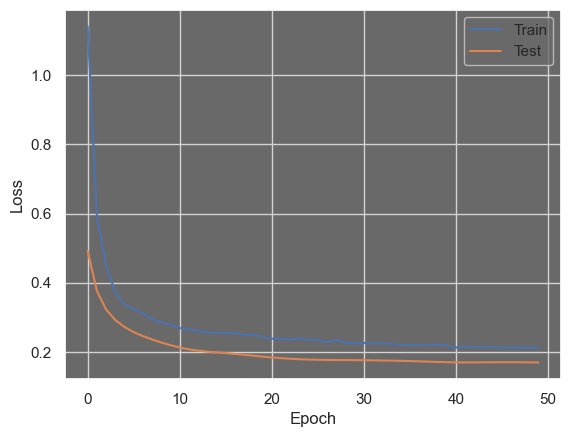

In [21]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [22]:
# class 1 lict
# class 0 ilicit
c, w = get_ilicit_predictions(GAT, loader, test_mask, device)
c, w = c[0], w[0]
print(c.shape, w.shape)

(644,) (264,)


In [23]:
explainer = Explainer(
    model=GAT,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    )
)
explanation_correct = explainer(data.x, data.edge_index, index=c)
explanation_wrong = explainer(data.x, data.edge_index, index=w)

KeyboardInterrupt: 

In [ ]:
fid_pm = fidelity(explainer, explanation_correct)
print(fid_pm)
explanation_correct.visualize_graph('subgraph_correct.png', backend="networkx")


fid_pm = fidelity(explainer, explanation_wrong)
print(fid_pm)
explanation_wrong.visualize_graph('subgraph_wrong.png', backend="networkx")

2.3836805555555554 3.343787408207732 576
3.538793103448276 16.129547054972534 232


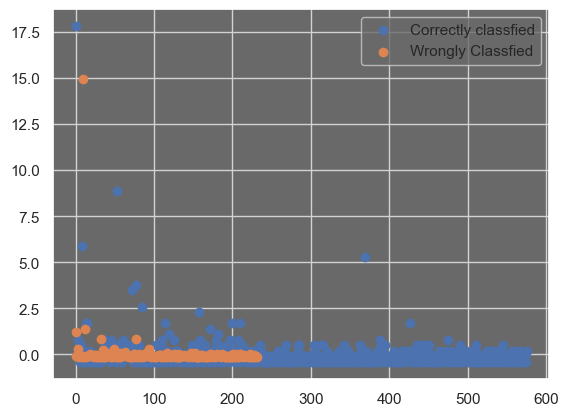

In [24]:
import numpy as np

degree_correct = []
degree_wrong = []
for node in c:
    try:
        degree_correct.append(G.degree(node))
    except:
        continue
for node in w:
    try:
        degree_wrong.append(G.degree(node))
    except:
        continue
print(np.mean(degree_correct), np.std(degree_correct), len(degree_correct))
print(np.mean(degree_wrong),np.std(degree_wrong), len(degree_wrong))

normalized_correct = (np.array(degree_correct) - np.mean(degree_correct)) / np.std(degree_correct)
normalized_wrong = (np.array(degree_wrong) - np.mean(degree_wrong)) / np.std(degree_wrong)

plt.scatter(np.arange(len(degree_correct)), normalized_correct, label="Correctly classfied")
plt.scatter(np.arange(len(degree_wrong)), normalized_wrong, label="Wrongly Classfied")
plt.legend()
plt.show()

In [25]:
from scipy.stats import mannwhitneyu, ks_2samp

U1, p = mannwhitneyu(degree_correct, degree_wrong, method="auto",  alternative="two-sided")
print(U1, p)

res = ks_2samp(degree_correct, degree_wrong)
print(res)

64454.5 0.40758229308723115
KstestResult(statistic=0.030052681992337165, pvalue=0.9970505220389432, statistic_location=1, statistic_sign=1)


In [ ]:
from sklearn.manifold import TSNE

untrained_gat = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)

# Get embeddings
h = untrained_gat(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

In [ ]:
# Get embeddings
checkpoint = torch.load("gat.pt", map_location=device)
GAT = GraphAttentionNetwork(node_dim=data["train"][0].x.shape[1], output_dim=2, hidden_dim=256, n_gnn_layers=1, heads=2, dropout_rate=0.5).to(device)
GAT.load_state_dict(checkpoint["net"])

h = GAT(data["train"][0])

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
            init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data["train"][0].y)
plt.show()

In [19]:
%run FeatureAggregationModel.ipynb
SFA = SpatialFeatureAggregator(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

In [22]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(SFA.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_loss = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(SFA, loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(SFA, loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(SFA)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "SFA.pt")

Epoch:  10
0 ({'precision': 0.9111389236545682, 'recall': 0.801762114537445, 'f1-score': 0.8529584065612186, 'support': 908})
1 ({'precision': 0.9788533834586466, 'recall': 0.9915506366773771, 'f1-score': 0.9851610996157256, 'support': 8403})
accuracy (0.9730426377403072)
macro avg ({'precision': 0.9449961535566074, 'recall': 0.8966563756074111, 'f1-score': 0.9190597530884721, 'support': 9311})
weighted avg ({'precision': 0.9722499327549518, 'recall': 0.9730426377403072, 'f1-score': 0.9722688168004003, 'support': 9311})
############################
Epoch:  20
0 ({'precision': 0.929471032745592, 'recall': 0.8127753303964758, 'f1-score': 0.8672150411280847, 'support': 908})
1 ({'precision': 0.9800399201596807, 'recall': 0.9933357134356777, 'f1-score': 0.9866430260047282, 'support': 8403})
accuracy (0.9757276339813125)
macro avg ({'precision': 0.9547554764526363, 'recall': 0.9030555219160767, 'f1-score': 0.9269290335664064, 'support': 9311})
weighted avg ({'precision': 0.9751084896181715,

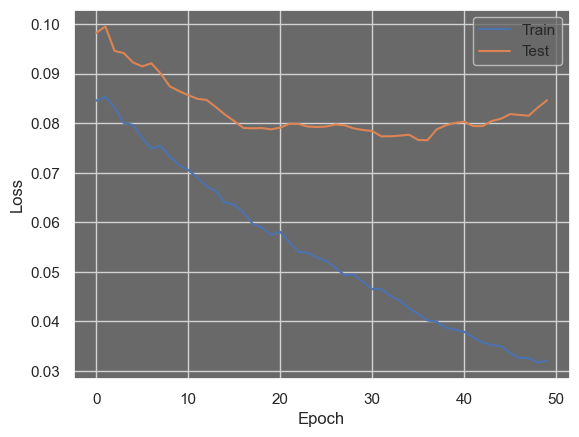

In [23]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
%run LSTM_GNN.ipynb
TB = TemporalBoy(node_dim=data.x.shape[1], edge_dim=1, output_dim=2, hidden_dim=256, n_gnn_layers=3, K=2, dropout_rate=0.1).to(device)

D:\Python\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [30]:
lr = 1e-3
epochs = 50
# weights for classes
weight = torch.tensor([0.5, 0.5]).to(device)
optimizer = torch.optim.Adam(TB.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []
best_test_loss = 1e9

for epoch in range(1, 1 + epochs):
    # train with random split
    train_losses = []
test_losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(TB, loader,train_mask, optimizer, loss_fn, device)
    train_losses.append(loss)
    result, test_loss = test(TB, loader,loss_fn,test_mask, device)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = copy.deepcopy(TB)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        for item, amount in result.items():
                print("{} ({})".format(item, amount))
        print("############################")
state = {"net":best_model.state_dict(), "optimizer":optimizer.state_dict()}
torch.save(state, "TB.pt")

Epoch:  10
0 ({'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 908})
1 ({'precision': 0.9024809365266888, 'recall': 1.0, 'f1-score': 0.9487411087275601, 'support': 8403})
accuracy (0.9024809365266888)
macro avg ({'precision': 0.4512404682633444, 'recall': 0.5, 'f1-score': 0.47437055436378006, 'support': 9311})
weighted avg ({'precision': 0.8144718407940894, 'recall': 0.9024809365266888, 'f1-score': 0.8562207643258176, 'support': 9311})
############################
Epoch:  20
0 ({'precision': 0.6880733944954128, 'recall': 0.08259911894273128, 'f1-score': 0.14749262536873156, 'support': 908})
1 ({'precision': 0.9094762008259074, 'recall': 0.9959538260145187, 'f1-score': 0.9507526270945754, 'support': 8403})
accuracy (0.9068843303619375)
macro avg ({'precision': 0.7987747976606601, 'recall': 0.539276472478625, 'f1-score': 0.5491226262316535, 'support': 9311})
weighted avg ({'precision': 0.8878852065021947, 'recall': 0.9068843303619375, 'f1-score': 0.8724194640007009, 'support

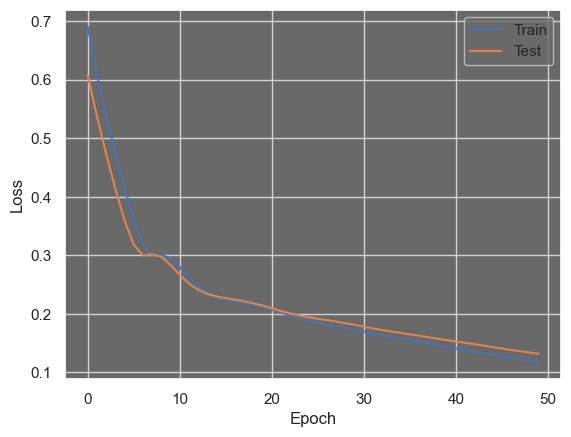

In [31]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()